In [1]:
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline
import torch.nn as nn

In [2]:
import torch.nn.functional as F

class SSD(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes

        self.vgg = nn.ModuleList(vgg(vgg_base[str(300)], 3)) 
        self.L2Norm = L2Norm(512, 20)
        self.extras = nn.ModuleList(add_extras(extras_base[str(300)], 1024))  
        self.loc = nn.ModuleList(location(n_boxes, vgg_base[str(300)])) 
        self.conf = nn.ModuleList(confidence(n_boxes, vgg_base[str(300)], self.num_classes)) 
        self.dbox_list = dbox_list() 


        self.vgg.apply(weights_init)
        self.L2Norm.apply(weights_init)
        self.extras.apply(weights_init)
        self.loc.apply(weights_init)
        self.conf.apply(weights_init)

    def forward(self, x):
        sources = list() 
        loc = list()  
        conf = list()  

        for k in range(23):
            x = self.vgg[k](x)

        source1 = self.L2Norm(x)
        sources.append(source1)


        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

     
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  
                sources.append(x)

        
        for (x, l, c) in zip(sources, self.loc, self.conf):
         
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

       
        
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference": 
         
            return Detect(output[0], output[1], output[2])

In [4]:
def ssd_predict(img_index, img_list, dataset, net=None, dataconfidence_level=0.5):
    
    image_file_path = img_list[img_index]
    img = cv2.imread(image_file_path) 
    height, width, channels = img.shape 
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    im, gt = dataset.__getitem__(img_index)
    true_bbox = gt[:, 0:4] * [width, height, width, height]
    true_label_index = gt[:, 4].astype(int)


    net.eval()  
    x = im.unsqueeze(0)  
    detections = net(x)


    predict_bbox = []
    pre_dict_label_index = []
    scores = []
    detections = detections.cpu().detach().numpy()


    find_index = np.where(detections[:, 0:, :, 0] >= dataconfidence_level)
    detections = detections[find_index]
    for i in range(len(find_index[1])): 
        if (find_index[1][i]) > 0: 
            sc = detections[i][0]  
            bbox = detections[i][1:] * [width, height, width, height]
            lable_ind = find_index[1][i]-1 
            
            predict_bbox.append(bbox)
            pre_dict_label_index.append(lable_ind)
            scores.append(sc)

    return rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores


In [5]:
def vis_bbox(rgb_img, bbox, label_index, scores, label_names):
    

    num_classes = len(label_names)
    colors = plt.cm.hsv(np.linspace(0, 1, num_classes)).tolist()


    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_img)
    currentAxis = plt.gca()


    for i, bb in enumerate(bbox):


        label_name = label_names[label_index[i]]
        color = colors[label_index[i]] 


        if scores is not None:
            sc = scores[i]
            display_txt = '%s: %.2f' % (label_name, sc)
        else:
            display_txt = '%s: ans' % (label_name)


        xy = (bb[0], bb[1])
        width = bb[2] - bb[0]
        height = bb[3] - bb[1]

        currentAxis.add_patch(plt.Rectangle(
            xy, width, height, fill=False, edgecolor=color, linewidth=2))


        currentAxis.text(xy[0], xy[1], display_txt, bbox={
                         'facecolor': color, 'alpha': 0.5})


In [6]:
class SSDPredictShow():


    def __init__(self, img_list, dataset,  eval_categories, net=None, dataconfidence_level=0.6):
        self.img_list = img_list
        self.dataset = dataset
        self.net = net
        self.dataconfidence_level = dataconfidence_level
        self.eval_categories = eval_categories

    def show(self, img_index, predict_or_ans):
       
        rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores = ssd_predict(img_index, self.img_list,
                                                                 self.dataset,
                                                                 self.net,
                                                                 self.dataconfidence_level)

        if predict_or_ans == "predict":
            vis_bbox(rgb_img, bbox=predict_bbox, label_index=pre_dict_label_index,
                     scores=scores, label_names=self.eval_categories)

        elif predict_or_ans == "ans":
            vis_bbox(rgb_img, bbox=true_bbox, label_index=true_label_index,
                     scores=None, label_names=self.eval_categories)


In [7]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn



rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)  
input_size = 300 

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))



In [9]:


voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']


ssd_cfg = {
    'num_classes': 21, 
    'input_size': 300,  
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4], 
    'feature_maps': [38, 19, 10, 5, 3, 1],  
    'steps': [8, 16, 32, 64, 100, 300], 
    'min_sizes': [30, 60, 111, 162, 213, 264],  
    'max_sizes': [60, 111, 162, 213, 264, 315], 
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}


net = SSD(phase="inference", cfg=ssd_cfg)

net_weights = torch.load('./weights/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})


net.load_state_dict(net_weights)



<All keys matched successfully>

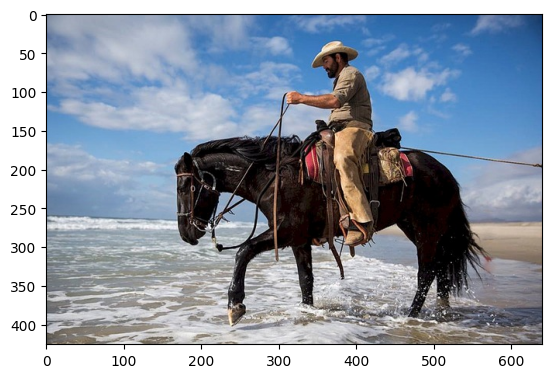

In [11]:
from utils.ssd_model import DataTransform


image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  
height, width, channels = img.shape  


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


color_mean = (104, 117, 123) 
input_size = 300 
transform = DataTransform(input_size, color_mean)

phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "") 
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)


net.eval()  
x = img.unsqueeze(0)  




In [14]:
from utils.ssd_predict_show import SSDPredictShow


image_file_path = "./data/cowboy-757575_640.jpg"


ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)


RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)